# CLIP + SAM

In [3]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, build_sam_vit_b
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
torch.cuda.empty_cache()
mask_generator = SamAutomaticMaskGenerator(build_sam_vit_b(checkpoint="sam_vit_b_01ec64.pth"))
mask_generator.predictor.model.to('cuda').eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
mask_generator.predictor.model.device

device(type='cuda', index=0)

In [6]:
image_path = "data_from_runs/data_1743688590_329291105/(1743688590, 391632318)/rgb_image.png"

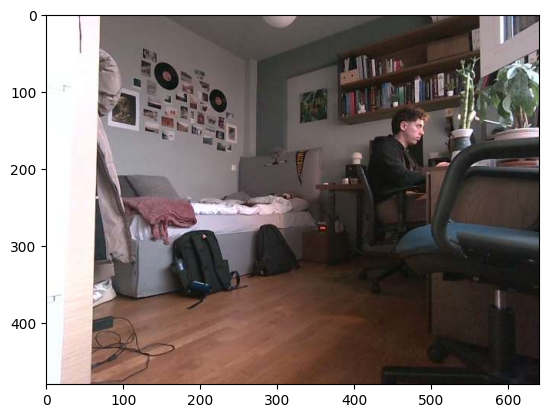

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (128,128))
plt.imshow(image)
with torch.inference_mode():
    masks = mask_generator.generate(image)

In [8]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [11]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [12]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [18]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [14]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [15]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

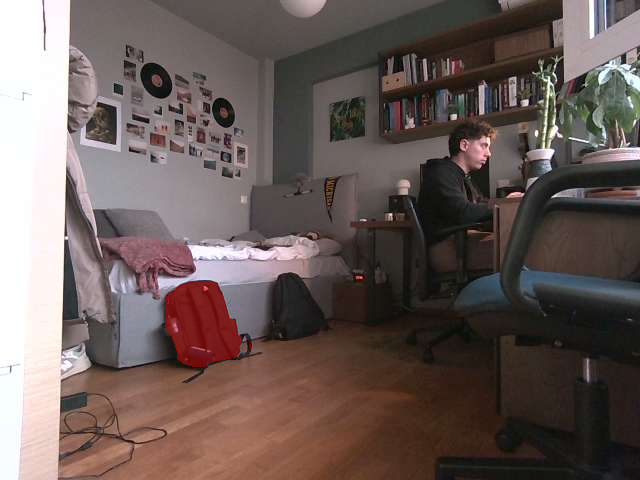

In [21]:
scores = retriev(cropped_boxes, "backpack")
indices = get_indices_of_values_above_threshold(scores, 0.05)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)

original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 100)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image